## **Packet Sniffing and Spoofing Lab**

Lab Link : https://seedsecuritylabs.org/Labs_20.04/Files/Sniffing_Spoofing/Sniffing_Spoofing.pdf <br>
Usefuls tools: *Wireshark, Netwox, Scapy*

#### Lab Objectives
- How the sniffing and spoofing work
- Packet sniffing using the pcap library and Scapy
- Packet spoofing using raw socket and Scapy
- Manipulating packets using Scapy

In this lab, we will use three machines that are connected to the same LAN. We can either use three VMs or three containers. We will do all the attacks on the attacker container, while using the other containers as the user machines.


### **Task 1.1A**

using the `ifconfig`. We determine the network interface that we will sniff the packets from. In our case the interface is `br-fedef2ddde0a`

##### Python Code:

In [ ]:
#!/usr/bin/env python3
from scapy.all import *

def print_pkt(pkt):
  pkt.show()

pkt = sniff(iface='br-fedef2ddde0a',filter='icmp', prn=print_pkt)

Note that running this code without root privileges will not work. Switching to the attacker container is required.

### Steps Done:
1. Run script from Attacker Container.
2. Switch to the host VM and ping any other machine.
3. Observe the Captured Packets on the Attacker Terminal.










### **Task 1.1B**

Scapy's filter use the the BPF (Berkeley Packet Filter) syntax, helping us observe certain types of packets.

**BPF Cheat Sheet**: https://twitter.com/b0rk/status/1100994090823491584

In [ ]:
### Capture only the ICMP packet

#!/usr/bin/env python3
from scapy.all import *

def print_pkt(pkt):
  pkt.show()

pkt = sniff(iface='br-fedef2ddde0a',filter='icmp', prn=print_pkt)

In [ ]:
### Capture any TCP packet that comes from a particular IP and with a destination port number 23

#!/usr/bin/env python3
from scapy.all import *

def print_pkt(pkt):
  pkt.show()

pkt = sniff(iface='br-fedef2ddde0a',filter='tcp and src host 10.9.0.6 and dst port 23', prn=print_pkt)

In [ ]:
### Capture  packets  comes  from  or  to  go  to  a  particular  subnet.   
### You  can  pick  any  subnet,  such  as 128.230.0.0/16; 
### you should not pick the subnet that your VM is attached to.

#!/usr/bin/env python3
from scapy.all import *

def print_pkt(pkt):
  pkt.show()

pkt = sniff(iface='br-fedef2ddde0a',filter='net 128.230.0.0/16', prn=print_pkt)

------------------------------------------------------------------------------------------------------------------------

### **Task 1.2: Spoofing ICMP Packets**

As a packet spoofing tool,Scapy allows us to set the fields of IP packets to arbitrary values.The objective of this task is to spoof IP packets with an arbitrary source IP address.We will spoof ICMP echo request packets,and send them to another VM on the same network.We will use Wireshark to observe whether our request will be accepted by the receiver. If it is accepted,an echo reply packet will be sent to the spoofed IP address.

In [ ]:
from scapy.all import *
a = IP() ##Create an IP object from the IP class
a.dst = '10.0.2.3' ##Set ip dst
b = ICMP() ##Create an ICMP object 
p = a / b ## Make 
send(p)


In [ ]:
## Spoofing an IP packet and sending it
from scapy.all import *
a = IP() ##Create an IP object from the IP class
a.src = '10.0.2.3' ##Set ip src for spoofing
a.dst = '10.9.0.5'
b = ICMP() ##Create an ICMP object 
p = a / b ## Make a packet using the IP object and the ICMP payload field
send(p)

Executing this code does what's expected by sending ICMP echo requests to the stated dst ip using the spoofes src ip and
by observing wireshark, we have indeed received an echo reply from the dst IP `10.9.0.5` to the spoofed IP `10.0.2.3`; thus giving us info that the target is indeed available and running while also hiding our IP from them.

### **Task 1.3: Traceroute**

The idea is quite straight forward: just send a packet(any type)to the destination,with its Time-To-Live(TTL)field set to 1 first.This packet will be dropped by the first router, which will send us an ICMP error message,telling us that the time-to-live has exceeded.That is how we get the IP address of the first router.We then increase our TTL field to 2,send out another packet,and get the IP address of the second router.We will repeat this procedure until our packet finally reach the destination. It should be noted that this experiment only gets an estimated result,because in theory,not all these packets take the same route(but inpractice, they may within a short period of time.

In [ ]:
from scapy.all import *

def find_ttl(ttl, target):
    a = IP()
    b = ICMP()  # Create an ICMP object
    a.ttl = ttl
    a.dst = target
    p = a / b
    response = sr1(p) ## sends and receives 1 packet  hence the '1' 
    if response.src == target:
        print(f'TTls required to reach {response.src} is {ttl}')
    else:
    	find_ttl(ttl+1, target)

def main():
    initial_ttl = 1
    target = '1.2.3.4' ## Based on the output, this specific dest ip seems to have implemented some kind of firewall that detects low ttl and/or suspicious packets
    # target = '8.8.8.8'
    find_ttl(initial_ttl, target)

if __name__ == "__main__":
    main()


### **Task 1.4:  Sniffing and-then Spoofing**
#### Prerequisites:
- Scapy
- 2 Machines on the same LAN (The VM and the user container).
- The workings of the ARP Protocol and Routing.
 #### Objective:
A sniff and spoof program that runs on the VM, to monitor the LAN and sniffs any **`ICMP echo request`** packets coming from the user container who is attempting to ping machine X. Regardless of whether macine X is alive, our program will response to the user container with an echo reply indicating that X is alive. Below are the IP addresses we will ping and report on from the user container. 

1. **ping** `10.9.0.99` **# a non-existing host on the LAN**<br>
2. **ping** `1.2.3.4` # **a non-existing host on the Internet**<br>
3. **ping** `8.8.8.8` # **an existing host on the Internet**<br>

**Tip:** this command `ip route get x.x.x.x` helps finds the router for a specified destination.

In [ ]:
#!/usr/bin/env python3
from scapy.all import *
def spoof_then_send_pkt(pkt):
   if pkt[ICMP].type == 8: ##check if its an ICMP request
    	a = IP(src=pkt[IP].dst,dst = pkt[IP].src) ##spoofinf by switching addresses
    	b = ICMP(type=0,id=pkt[ICMP].id,seq=pkt[ICMP].seq) ##Type 0 for reply 
    	p = a/b/pkt[Raw].load ##creating the final packet with the ip header,ICMP packet portion and the payload
    	print(f'Request Src: {pkt[IP].src} with Dst: {pkt[IP].dst}')
    	print(f'Reply Src: {pkt[IP].dst} with Dst: {pkt[IP].src}')
    	send(p)
pkt = sniff(iface =['enp0s3','br-fedef2ddde0a'],filter='icmp',prn=spoof_then_send_pkt) ##interfaces extracted from the ip route get command

As shown below, when the user container (terminal 2) pings `8.8.8.8` (an existing host on the internet), he recieves replies from the legitmate host, as well as our program and that explains the duplicated replies shown below.

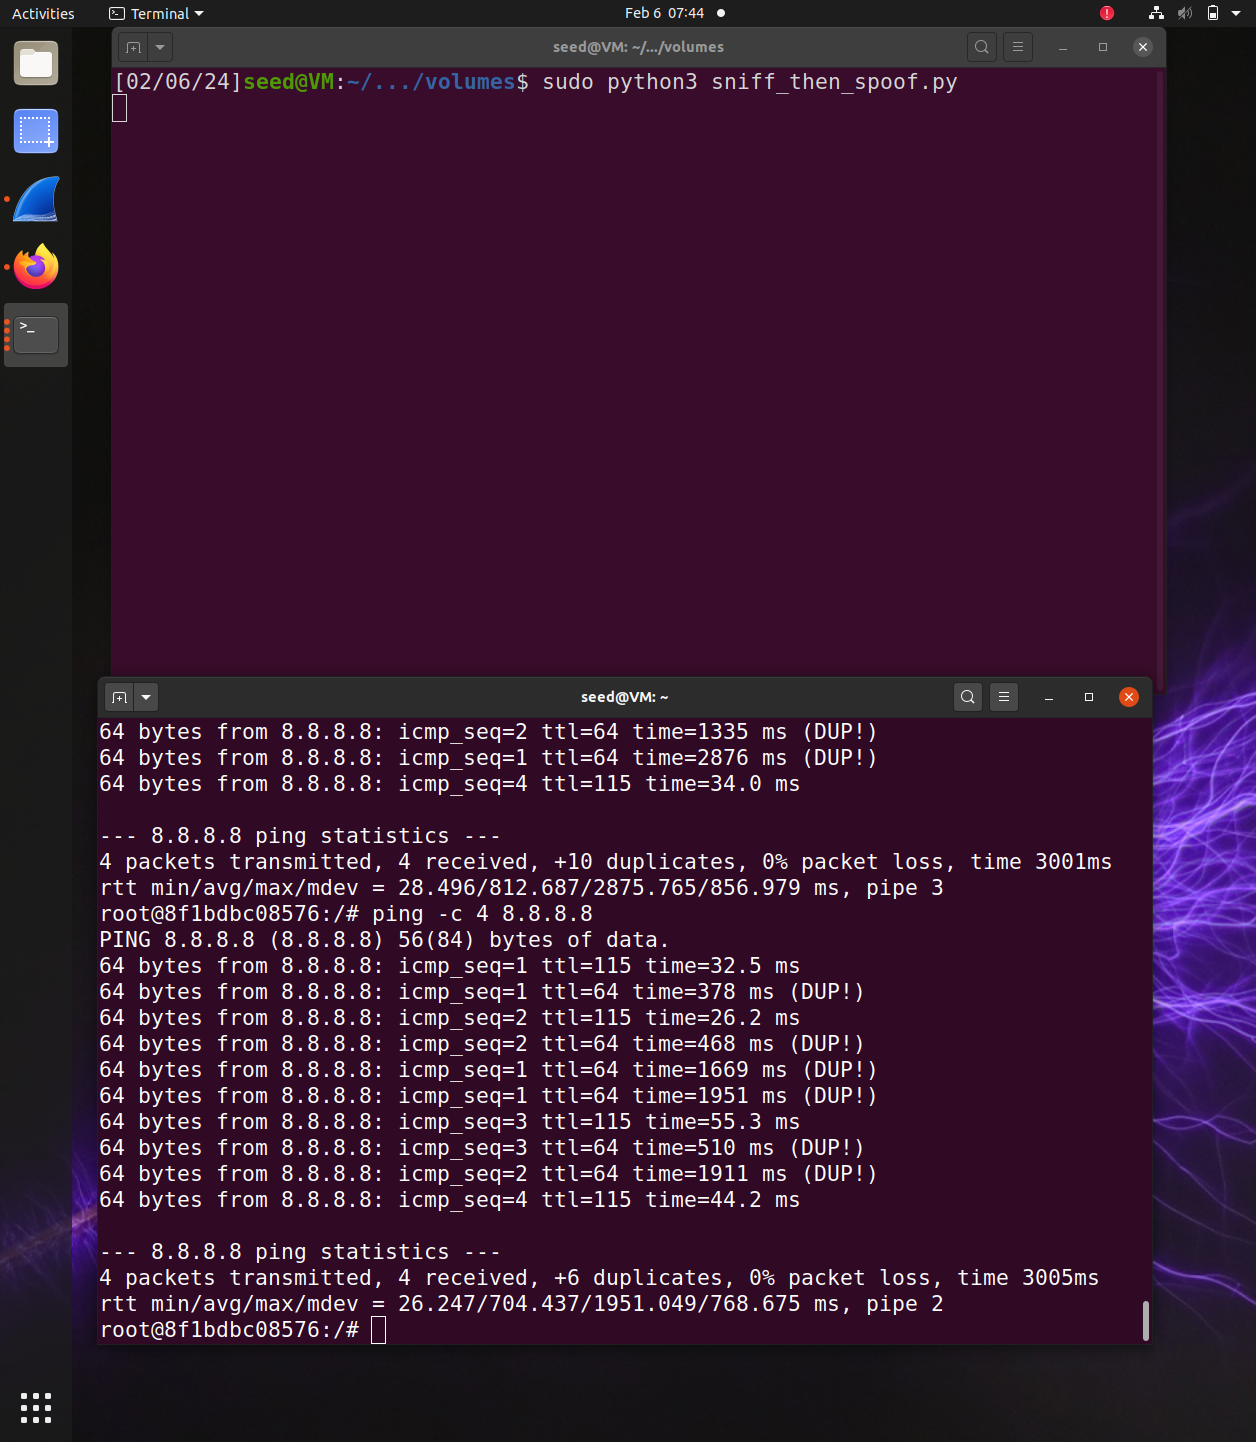

Similary, when the user container pings `1.2.3.4` (non-existing host on the internet) as shown below, the user receives packets strictly from our program without any duplicates as the host doesn't exist.

Lastly whenever the user pings the non-existing host on the LAN with ip `10.9.0.99`, an ARP request is sent and not an ICMP, thus our program doesn't reply to this specific request.

Wireshark showcasing the ARP requests:

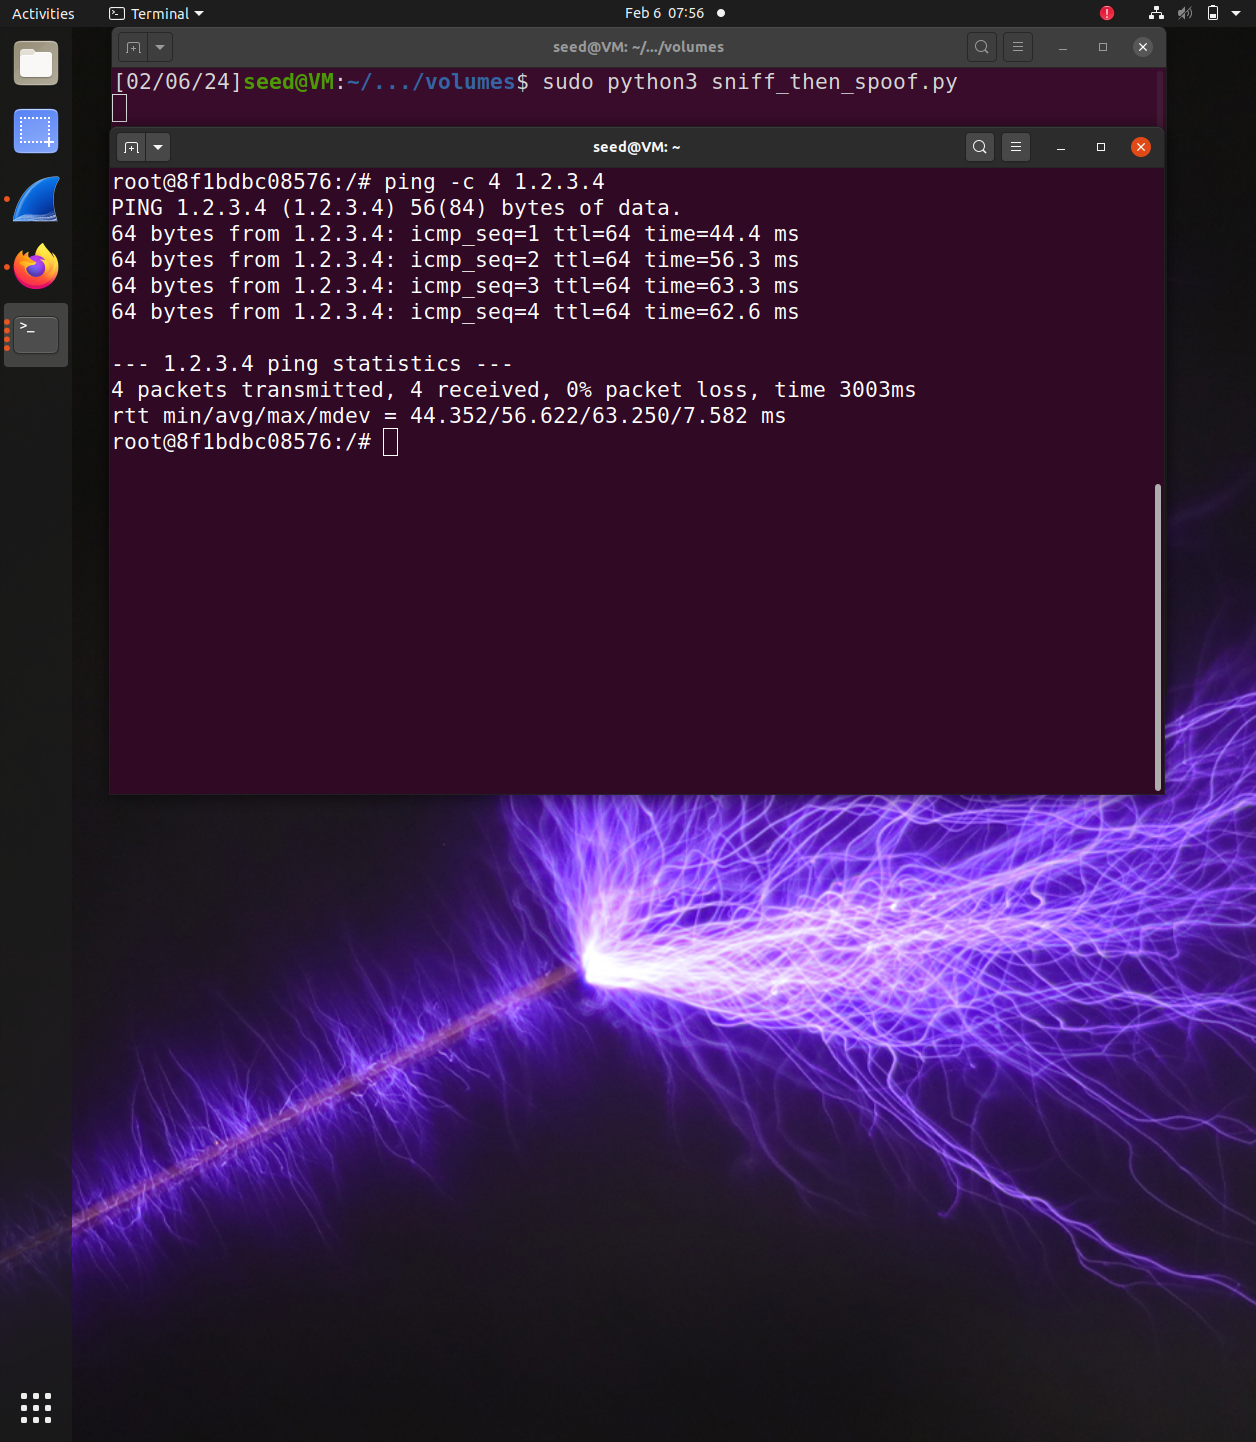